## 1. Setup

In [1]:
import sys
sys.path.append('../..')

In [2]:
import config
import matplotlib.pyplot as plt
import numpy as np
import os
import warnings

from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from neural_networks.seg_reg_net import SegRegNet
from neural_networks.keras_utils import EvalMetricsCallback
from utils.data.data_augmentation import augment16_from_dir_and_save
from utils.data.data_generator import DataGenerator
from utils.data.data_ops import move_val_split_to_train
from utils.data.data_ops import create_val_split_from_train
from utils.input_output.io import read_json, write_json
from utils.visualization.vis import plot_logs, plot_seg_reg_maps

Using TensorFlow backend.


In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

warnings.filterwarnings('ignore')

## 2. Load the dataset

#### Create validation split from the initial training data

In [4]:
'''
move_val_split_to_train(config.VAL_PATH, config.TRAIN_PATH)
create_val_split_from_train(config.TRAIN_PATH, config.VAL_PATH, config.VAL_SIZE, config.RAND_SEED)
'''

'\nmove_val_split_to_train(config.VAL_PATH, config.TRAIN_PATH)\ncreate_val_split_from_train(config.TRAIN_PATH, config.VAL_PATH, config.VAL_SIZE, config.RAND_SEED)\n'

#### Data augmentation (train/val split)

In [5]:
'''
augment16_from_dir_and_save(in_path=config.TRAIN_PATH,
                            save_path=config.TRAIN_PATH,
                            rseed=config.RAND_SEED)

augment16_from_dir_and_save(in_path=config.VAL_PATH,
                            save_path=config.VAL_PATH,
                            rseed=config.RAND_SEED + 1)
'''

'\naugment16_from_dir_and_save(in_path=config.TRAIN_PATH,\n                            save_path=config.TRAIN_PATH,\n                            rseed=config.RAND_SEED)\n\naugment16_from_dir_and_save(in_path=config.VAL_PATH,\n                            save_path=config.VAL_PATH,\n                            rseed=config.RAND_SEED + 1)\n'

#### Data generators

In [6]:
train_params = {
    'dim': config.PATCH_DIM,
    'batch_size': config.BATCH_SIZE,
    'patches_per_image': config.PATCHES_PER_IMAGE,
    'density_map_multiplication_factor': config.DENSITY_MAP_MULTIPLICATION_FACTOR,
    'shuffle': config.SHUFFLE,
    'ignored_images': config.IGNORED_IMAGES,
    'data_augmentation': True,
    'output_mode': 'seg_reg',
    'gt_seg_thr': config.GT_SEG_THR
}

val_params = {
    'dim': config.IMG_DIM,
    'batch_size': 1,
    'patches_per_image': 1,
    'density_map_multiplication_factor': config.DENSITY_MAP_MULTIPLICATION_FACTOR,
    'shuffle': False,
    'data_augmentation': True,
    'output_mode': 'seg_reg',
    'gt_seg_thr': config.GT_SEG_THR
}

In [7]:
train_generator = DataGenerator(config.DATASET_PATH, 'train', **train_params)
val_generator = DataGenerator(config.DATASET_PATH, 'val', **val_params)

## 3. Instantiate a SegRegNet

In [8]:
model = SegRegNet(seg_loss_name=config.SEG_LOSS_NAME,
                  reg_loss_name=config.REG_LOSS_NAME,
                  loss_weights=[1, 0],
                  learning_rate=config.LEARNING_RATE)

## 4. Train the model

In [9]:
!rm -rf $config.CHECKPOINTS_PATH
!rm -rf $config.LOGS_PATH
os.makedirs(config.CHECKPOINTS_PATH)
os.makedirs(config.LOGS_PATH)

### Seg training

In [10]:
%%time
model_checkpoint = ModelCheckpoint(config.CHECKPOINT_FILENAME,
                                   monitor='val_loss',
                                   save_best_only=True)

model_history = model.fit_generator(generator=train_generator,
                                    validation_data=val_generator,
                                    epochs=config.SEG_EPOCHS,
                                    callbacks=[model_checkpoint],
                                    verbose=1)

Epoch 1/3
14400/14400 [==============================] - 13027s 905ms/step - loss: 0.1115 - activation_1_loss: 0.1115 - conv2d_12_loss: 0.0594 - val_loss: 0.0753 - val_activation_1_loss: 0.0753 - val_conv2d_12_loss: 0.0603
Epoch 2/3
14400/14400 [==============================] - 13041s 906ms/step - loss: 0.0600 - activation_1_loss: 0.0600 - conv2d_12_loss: 0.0584 - val_loss: 0.0576 - val_activation_1_loss: 0.0576 - val_conv2d_12_loss: 0.0621
Epoch 3/3
14400/14400 [==============================] - 12909s 896ms/step - loss: 0.0490 - activation_1_loss: 0.0490 - conv2d_12_loss: 0.0598 - val_loss: 0.0499 - val_activation_1_loss: 0.0499 - val_conv2d_12_loss: 0.0632
CPU times: user 22h 37min 36s, sys: 5h 41min 27s, total: 1d 4h 19min 3s
Wall time: 10h 49min 44s


#### Save and load train stats/logs/history

In [11]:
def save_logs(model):
    logs = model.history.history.copy()

    logs['train_loss'] = logs.pop('loss')
    logs['train_size'] = train_generator.get_size()
    logs['val_size'] = val_generator.get_size()
    logs['rand_seed'] = config.RAND_SEED
    logs['shuffle'] = config.SHUFFLE
    logs['seg_loss_name'] = config.SEG_LOSS_NAME
    logs['reg_loss_name'] = config.REG_LOSS_NAME
    logs['img_dim'] = config.IMG_DIM
    logs['patch_dim'] = config.PATCH_DIM
    logs['patches_per_image'] = config.PATCHES_PER_IMAGE
    logs['density_map_sigma'] = config.GT_SIGMA
    logs['density_map_multiplication_factor'] = config.DENSITY_MAP_MULTIPLICATION_FACTOR
    logs['sub_experiment_name'] = config.SUB_EXPERIMENT_NAME
    logs['architecture'] = config.ARCHITECTURE_NAME
    
    return logs

min val_loss: 0.0499, epoch: 3


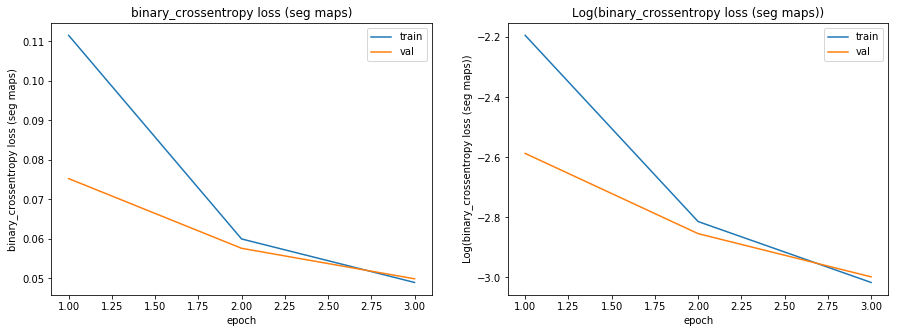

In [12]:
seg_logs = save_logs(model)
write_json(seg_logs, config.SEG_LOGS_FILENAME)
seg_logs = read_json(config.SEG_LOGS_FILENAME)

print(f'min val_loss: {np.min(seg_logs["val_loss"]):.4f}, epoch: {1 + np.argmin(seg_logs["val_loss"])}')

plot_logs(seg_logs['train_loss'], seg_logs['val_loss'], f'{config.SEG_LOSS_NAME} loss (seg maps)')

#### Load the best model

In [13]:
model = SegRegNet(seg_loss_name=config.SEG_LOSS_NAME,
                  reg_loss_name=config.REG_LOSS_NAME,
                  loss_weights=[1, 0],
                  learning_rate=config.LEARNING_RATE,
                  pretrained_weights=config.CHECKPOINT_FILENAME)

#### Look at one example from the validation set

In [14]:
img, (gt_seg_map, gt_density_map) = val_generator.__getitem__(1)
pred_seg_map, pred_density_map = model.predict(img)

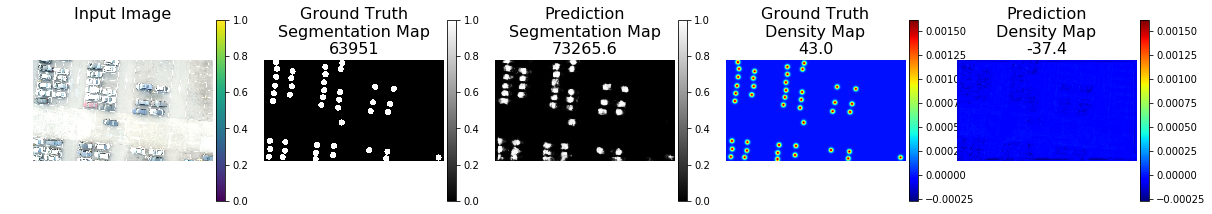

In [15]:
plot_seg_reg_maps(img.squeeze(), gt_seg_map, pred_seg_map, gt_density_map, pred_density_map,
                  config.DENSITY_MAP_MULTIPLICATION_FACTOR)

#### Set trainable=False for all layers of encoder

In [16]:
for idx in range(8):
    model.layers[idx].trainable = False

for layer in model.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7fab2c2a4a20> False
<keras.layers.convolutional.Conv2D object at 0x7fab2c2a4080> False
<keras.layers.pooling.MaxPooling2D object at 0x7fab2c2a4908> False
<keras.layers.convolutional.Conv2D object at 0x7fab2c2a9390> False
<keras.layers.pooling.MaxPooling2D object at 0x7fab2c1f9898> False
<keras.layers.convolutional.Conv2D object at 0x7fab2c1f9d68> False
<keras.layers.pooling.MaxPooling2D object at 0x7fab2c1e0470> False
<keras.layers.convolutional.Conv2D object at 0x7fab2c1e0908> False
<keras.layers.convolutional.UpSampling2D object at 0x7fab2c15d898> True
<keras.layers.convolutional.Conv2D object at 0x7fab2c1794e0> True
<keras.layers.convolutional.UpSampling2D object at 0x7fab2c0a3a20> True
<keras.layers.convolutional.UpSampling2D object at 0x7fab2c196ac8> True
<keras.layers.convolutional.Conv2D object at 0x7fab2c0bedd8> True
<keras.layers.convolutional.Conv2D object at 0x7fab2c196048> True
<keras.layers.convolutional.UpSampling2D object 

### Reg training

#### Prepare the model for the training

In [17]:
model.compile(optimizer=Adam(lr=config.LEARNING_RATE),
              loss=[config.SEG_LOSS_NAME, config.REG_LOSS_NAME],
              loss_weights=[0, 1])

#### Training time

In [18]:
%%time
model_checkpoint = ModelCheckpoint(config.CHECKPOINT_FILENAME_VAR,
                                   monitor='val_loss',
                                   save_best_only=False)

model_history = model.fit_generator(generator=train_generator,
                                    validation_data=val_generator,
                                    epochs=config.REG_EPOCHS,
                                    callbacks=[model_checkpoint],
                                    verbose=1)

Epoch 1/3
14400/14400 [==============================] - 10612s 737ms/step - loss: 0.0122 - activation_2_loss: 0.0437 - conv2d_24_loss: 0.0122 - val_loss: 0.0113 - val_activation_2_loss: 0.0499 - val_conv2d_24_loss: 0.0113
Epoch 2/3
14400/14400 [==============================] - 10610s 737ms/step - loss: 0.0093 - activation_2_loss: 0.0437 - conv2d_24_loss: 0.0093 - val_loss: 0.0102 - val_activation_2_loss: 0.0499 - val_conv2d_24_loss: 0.0102
Epoch 3/3
14400/14400 [==============================] - 10597s 736ms/step - loss: 0.0084 - activation_2_loss: 0.0437 - conv2d_24_loss: 0.0084 - val_loss: 0.0098 - val_activation_2_loss: 0.0499 - val_conv2d_24_loss: 0.0098
CPU times: user 20h 50min 36s, sys: 5h 35min 41s, total: 1d 2h 26min 17s
Wall time: 8h 50min 38s


min val_loss: 0.0098, epoch: 3


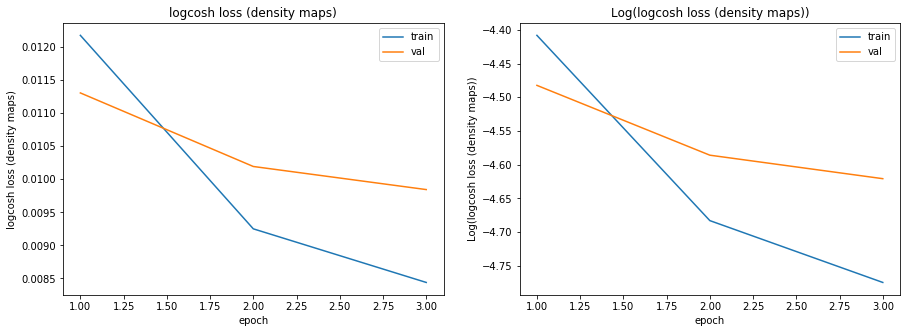

In [19]:
reg_logs = save_logs(model)
write_json(reg_logs, config.REG_LOGS_FILENAME)
reg_logs = read_json(config.REG_LOGS_FILENAME)

print(f'min val_loss: {np.min(reg_logs["val_loss"]):.4f}, epoch: {1 + np.argmin(reg_logs["val_loss"])}')

plot_logs(reg_logs['train_loss'], reg_logs['val_loss'], f'{config.REG_LOSS_NAME} loss (density maps)')

#### Load the best model (model.02 in this case)

In [20]:
!ls $config.CHECKPOINTS_PATH

best_model.hdf5  model.01-0.011.hdf5  model.02-0.010.hdf5  model.03-0.010.hdf5


In [21]:
model = SegRegNet(seg_loss_name=config.SEG_LOSS_NAME,
                  reg_loss_name=config.REG_LOSS_NAME,
                  loss_weights=[1, 0],
                  learning_rate=config.LEARNING_RATE,
                  pretrained_weights=f'{config.CHECKPOINTS_PATH}/model.02-0.010.hdf5')

#### Look at one example from the validation set

In [22]:
img, (gt_seg_map, gt_density_map) = val_generator.__getitem__(1)
pred_seg_map, pred_density_map = model.predict(img)

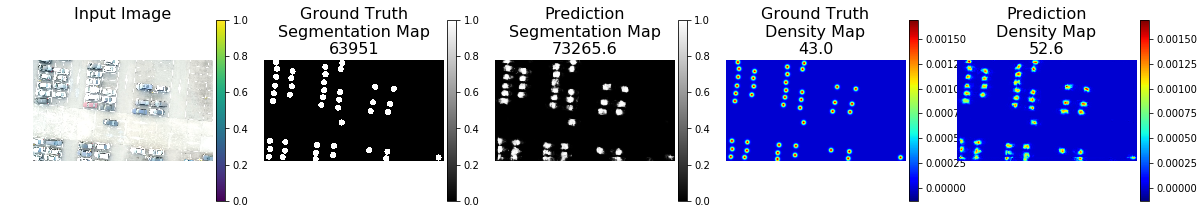

In [23]:
plot_seg_reg_maps(img.squeeze(), gt_seg_map, pred_seg_map, gt_density_map, pred_density_map,
                  config.DENSITY_MAP_MULTIPLICATION_FACTOR)